In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [149]:
# Set the default font family to Helvetica for all plots
plt.rcParams['font.family'] = 'sans-serif'

# Optional: You can also set other global font parameters like size if needed
plt.rcParams['font.size'] = 14  # Default font size for text
plt.rcParams['axes.labelsize'] = 14  # Font size for axis labels
plt.rcParams['xtick.labelsize'] = 14  # Font size for x-tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y-tick labels
plt.rcParams['legend.fontsize'] = 14  # Font size for legends
plt.rcParams['figure.titlesize'] = 16  # Font size for figure titles

In [2]:
T = pd.read_csv('time_processed_data.csv')

DJID 3420, homo, Male, age 4.6 months
Dark: 44 cells, 2 GFP+ = 5%
Light: 29 cells, 1 GFP+ = 3%
Effect size (no GFP): -0.59
Effect size (GFP): -3.48


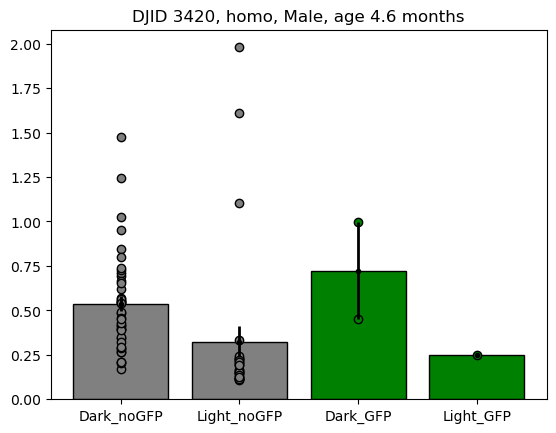

DJID 3529, wildtype, Female, age 2.2 months
Dark: 35 cells, 0 GFP+ = 0%
Light: 0 cells, 0 GFP+ = 0%
Effect size (no GFP): nan
No eGFP-positive cells present, skipping GFP effect size.


c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


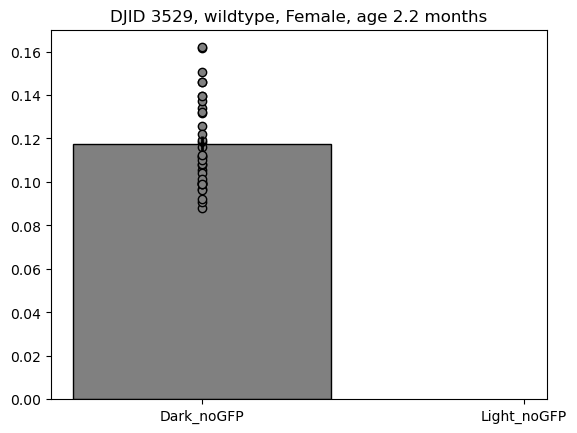

In [7]:
# Set response type
resp_type = 'glut1_membrane_over_wga_membrane'

animal_ids = T['DJID'].unique()

# Initialize storage
results = {
    'effect_size_noGFP': [],
    'effect_size_GFP': [],
    'genotype': [],
    'sex': [],
    'age': [],
    'animal_id': [],
    'n_cells': [],
    'frac_GFP': []
}

# Corrected calculate_ratios function
def calculate_ratios(df, ratio_type):
    if df.empty:
        return []
    if ratio_type == 'glut1_membrane_over_middle':
        denominator = df['GluT1_Middle_Integral'] * df['Length_um']
    elif ratio_type == 'glut1_membrane_over_wga_membrane':
        denominator = df['WGA_Top_Integral'] + df['WGA_Bottom_Integral']

    # Handle cases where the denominator might be zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = (df['GluT1_Top_Integral'] + df['GluT1_Bottom_Integral']) / denominator
        ratios = ratios.replace([np.inf, -np.inf], np.nan)  # Replace inf values with NaN
        return ratios.dropna().tolist()  # Drop NaN values and return as list

# Analysis loop
for a in animal_ids:
    T_thisAnimal = T[T['DJID'] == a]
    genotype, sex, age = T_thisAnimal.iloc[0][['Genotype', 'Sex', 'Age_Months']]
    N_cells = len(T_thisAnimal)

    T_dark = T_thisAnimal[T_thisAnimal['Experimental_Condition'] == 'Dark']
    T_light = T_thisAnimal[T_thisAnimal['Experimental_Condition'] == 'Light Flicker']

    T_dark_GFP, T_dark_noGFP = T_dark[T_dark['eGFP_Value'] > 0], T_dark[T_dark['eGFP_Value'] == 0]
    T_light_GFP, T_light_noGFP = T_light[T_light['eGFP_Value'] > 0], T_light[T_light['eGFP_Value'] == 0]

    frac_GFP = (len(T_dark_GFP) + len(T_light_GFP)) / N_cells if N_cells else 0

    print(f"DJID {a}, {genotype}, {sex}, age {age:.1f} months")
    print(f"Dark: {len(T_dark)} cells, {len(T_dark_GFP)} GFP+ = {100 * len(T_dark_GFP) / len(T_dark) if len(T_dark) else 0:.0f}%")
    print(f"Light: {len(T_light)} cells, {len(T_light_GFP)} GFP+ = {100 * len(T_light_GFP) / len(T_light) if len(T_light) else 0:.0f}%")
    
    ratios_dark_noGFP = calculate_ratios(T_dark_noGFP, resp_type)
    ratios_light_noGFP = calculate_ratios(T_light_noGFP, resp_type)
    ratios_dark_GFP = calculate_ratios(T_dark_GFP, resp_type)
    ratios_light_GFP = calculate_ratios(T_light_GFP, resp_type)

    response_vec_mean = [
        np.mean(ratios_dark_noGFP), np.mean(ratios_light_noGFP),
        np.mean(ratios_dark_GFP) if ratios_dark_GFP else np.nan, 
        np.mean(ratios_light_GFP) if ratios_light_GFP else np.nan
    ]
    response_vec_sd = [
        np.std(ratios_dark_noGFP), np.std(ratios_light_noGFP),
        np.std(ratios_dark_GFP) if ratios_dark_GFP else np.nan,
        np.std(ratios_light_GFP) if ratios_light_GFP else np.nan
    ]
    response_vec_sem = [
        np.std(ratios_dark_noGFP) / np.sqrt(len(ratios_dark_noGFP) - 1) if len(ratios_dark_noGFP) > 1 else np.nan,
        np.std(ratios_light_noGFP) / np.sqrt(len(ratios_light_noGFP) - 1) if len(ratios_light_noGFP) > 1 else np.nan,
        np.std(ratios_dark_GFP) / np.sqrt(len(ratios_dark_GFP) - 1) if len(ratios_dark_GFP) > 1 else np.nan,
        np.std(ratios_light_GFP) / np.sqrt(len(ratios_light_GFP) - 1) if len(ratios_light_GFP) > 1 else np.nan,
    ]

    # Calculate effect sizes
    effect_size_noGFP = (response_vec_mean[1] - response_vec_mean[0]) / np.mean([response_vec_sd[1], response_vec_sd[0]])
    effect_size_GFP = (response_vec_mean[3] - response_vec_mean[2]) / np.mean([response_vec_sd[3], response_vec_sd[2]]) if not np.isnan(response_vec_mean[2]) and not np.isnan(response_vec_mean[3]) else np.nan

    # Print effect sizes
    print(f"Effect size (no GFP): {effect_size_noGFP:.2f}")
    print(f"Effect size (GFP): {effect_size_GFP:.2f}" if not np.isnan(effect_size_GFP) else "No eGFP-positive cells present, skipping GFP effect size.")

    # Store results
    results['effect_size_noGFP'].append(effect_size_noGFP)
    results['effect_size_GFP'].append(effect_size_GFP)
    results['genotype'].append(genotype)
    results['sex'].append(sex)
    results['age'].append(age)
    results['animal_id'].append(a)
    results['n_cells'].append(N_cells)
    results['frac_GFP'].append(frac_GFP)

    # Plotting
    plt.bar(['Dark_noGFP', 'Light_noGFP'], response_vec_mean[0:2], color='gray', edgecolor='black')
    
    if len(ratios_dark_noGFP): plt.scatter(['Dark_noGFP'] * len(ratios_dark_noGFP), ratios_dark_noGFP, color='grey', edgecolors='black')
    if len(ratios_light_noGFP): plt.scatter(['Light_noGFP'] * len(ratios_light_noGFP), ratios_light_noGFP, color='grey', edgecolors='black')
    
    if not np.isnan(response_vec_mean[2]) and not np.isnan(response_vec_mean[3]):
        plt.bar(['Dark_GFP', 'Light_GFP'], response_vec_mean[2:4], color='green', edgecolor='black')
        if len(ratios_dark_GFP): plt.scatter(['Dark_GFP'] * len(ratios_dark_GFP), ratios_dark_GFP, color='green', edgecolor='black')
        if len(ratios_light_GFP): plt.scatter(['Light_GFP'] * len(ratios_light_GFP), ratios_light_GFP, color='green', edgecolor='black')

        plt.errorbar(['Dark_GFP', 'Light_GFP'], response_vec_mean[2:4], yerr=response_vec_sem[2:4], fmt='.', color='black', linewidth=2)

    plt.errorbar(['Dark_noGFP', 'Light_noGFP'], response_vec_mean[0:2], yerr=response_vec_sem[0:2], fmt='.', color='black', linewidth=2)

    plt.title(f"DJID {a}, {genotype}, {sex}, age {age:.1f} months")
    plt.show()

# Convert results to DataFrame
result_table = pd.DataFrame(results)
result_table = result_table.dropna(subset=['effect_size_noGFP'])


C:\Users\Luis\AppData\Local\Temp\ipykernel_11368\41355728.py:63: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Time_Condition', y='Mean', data=plot_df, color='blue' if genotype_to_plot == 'het' else 'red', ci=None)


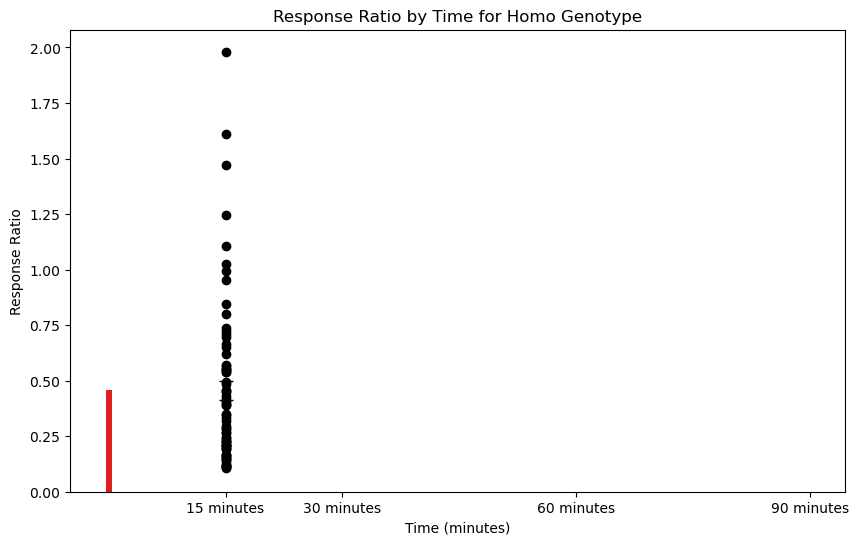

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming T is your DataFrame and it now has a 'Time_Condition' column with 15, 30, 60, 90 minutes.
# Also assuming 'Genotype' column has 'het' and 'homo'

# Set response type
resp_type = 'glut1_membrane_over_wga_membrane'

# Choose the genotype to plot ('het' or 'homo')
genotype_to_plot = 'homo'  # Change this to 'het' to plot for the 'het' genotype

# Function to calculate ratios
def calculate_ratios(df, ratio_type):
    if df.empty:
        return []
    if ratio_type == 'glut1_membrane_over_middle':
        denominator = df['GluT1_Middle_Integral'] * df['Length_um']
    elif ratio_type == 'glut1_membrane_over_wga_membrane':
        denominator = df['WGA_Top_Integral'] + df['WGA_Bottom_Integral']

    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = (df['GluT1_Top_Integral'] + df['GluT1_Bottom_Integral']) / denominator
        ratios = ratios.replace([np.inf, -np.inf], np.nan)
        return ratios.dropna().tolist()

# Initialize storage for plotting
plot_data = {
    'Time_Condition': [],
    'Mean': [],
    'SEM': [],
    'Ratios': []
}

# Define the time slots
time_slots = [15, 30, 60, 90]

# Loop over time slots
for time in time_slots:
    T_time_genotype = T[(T['Time_Condition'] == time) & (T['Genotype'] == genotype_to_plot)]
    ratios = calculate_ratios(T_time_genotype, resp_type)

    plot_data['Time_Condition'].append(time)  # Always append the time to ensure placeholders exist

    if ratios:
        plot_data['Mean'].append(np.mean(ratios))
        plot_data['SEM'].append(np.std(ratios) / np.sqrt(len(ratios)))
        plot_data['Ratios'].append(ratios)
    else:
        plot_data['Mean'].append(np.nan)
        plot_data['SEM'].append(np.nan)
        plot_data['Ratios'].append([])

# Convert plot data to DataFrame
plot_df = pd.DataFrame(plot_data)

# Plotting
plt.figure(figsize=(10, 6))

# Create bar plot with placeholders for missing data
sns.barplot(x='Time_Condition', y='Mean', data=plot_df, color='blue' if genotype_to_plot == 'het' else 'red', ci=None)

# Overlay scatter points, aligning them with the bar positions
for i, time in enumerate(plot_df['Time_Condition']):
    if plot_df.loc[i, 'Ratios']:
        plt.scatter([time] * len(plot_df.loc[i, 'Ratios']), plot_df.loc[i, 'Ratios'], color='black')

# Add error bars
plt.errorbar(x=plot_df['Time_Condition'], y=plot_df['Mean'], yerr=plot_df['SEM'], fmt='none', color='black', capsize=5)

# Ensure all time conditions have a placeholder on the x-axis
plt.xticks(ticks=[15, 30, 60, 90], labels=[f'{t} minutes' for t in time_slots])

plt.xlabel('Time (minutes)')
plt.ylabel('Response Ratio')
plt.title(f'Response Ratio by Time for {genotype_to_plot.capitalize()} Genotype')
plt.show()


In [5]:
T['Time_Condition'] = T['Time_Condition'].astype('category')


from pandas.api.types import CategoricalDtype

# Define the categories (replace with your specific categories)
categories = [15, 30, 60, 90]

# Apply the categorical dtype
cat_type = CategoricalDtype(categories=categories, ordered=True)  # Set ordered=False if order doesn't matter
T['Time_Condition'] = T['Time_Condition'].astype(cat_type)

T['Time_Condition'] = T['Time_Condition'].astype(str)


In [18]:
T

,DJID,Genotype,Eye,Sex,Age_Months,eGFP_Value,Experimental_Condition,In_Rip,Length_um,Time_Condition,GluT1_Top_Surface_Integral,GluT1_Bot_Surface_Integral,WGA_Top_Surface_Integral,WGA_Bot_Surface_Integral,GluT1_Top_Integral,GluT1_Middle_Integral,GluT1_Bottom_Integral,WGA_Top_Integral,WGA_Middle_Integral,WGA_Bottom_Integral
0,3420,homo,L,Male,4.6,0,Light Flicker,0,3.60,15,80319,59518,913270,342238,52774,186575,69711,643701,1719801,439743
1,3420,homo,L,Male,4.6,0,Light Flicker,0,3.60,15,417143,124234,1955723,853475,226650,1120746,145166,1211399,3685717,1040893
2,3420,homo,L,Male,4.6,0,Light Flicker,0,3.90,15,354529,87533,1243520,532593,183512,819646,92504,798149,2128818,643649
3,3420,homo,L,Male,4.6,0,Light Flicker,0,3.00,15,643845,324075,2067012,1270178,281562,2044906,275488,1037139,4627211,1405797
4,3420,homo,L,Male,4.6,0,Light Flicker,0,3.15,15,178305,108805,1411573,792742,79395,664534,108056,689795,2721191,959535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3529,wildtype,RD,Female,2.2,0,Dark,1,3.60,60,294764,51945,1985378,592661,205830,468759,35412,1339985,3666572,419401
104,3529,wildtype,RD,Female,2.2,0,Dark,0,3.00,60,339436,351420,2529407,2148109,156305,1791350,318616,1558811,5722971,2333218
105,3529,wildtype,RD,Female,2.2,0,Dark,0,3.00,60,232666,133524,1704636,1131220,104968,559619,149605,1011284,3214957,1249874
106,3529,wildtype,RD,Female,2.2,0,Dark,0,3.45,60,173266,223739,1336036,1165696,103975,753907,224035,850364,3250031,1174074


# Simulating Time Data

In [13]:
from numpy import random

In [157]:
sim_data = pd.DataFrame()

random.seed(20)
obs_len = 1000

def generate_true_false_array(len, true_percentage=0.2):
    num_true = int(true_percentage * len)
    arr = np.array([1] * num_true + [0] * (len - num_true))
    np.random.shuffle(arr)
    return arr

sim_data['Exp_Condition'] = random.choice(['Light Flicker', 'Dark'], obs_len)
sim_data['Time_Condition'] = random.choice(['15', '30', '60', '90'], obs_len)
sim_data['Ratios'] = np.abs(random.normal(0, 1, obs_len))
sim_data['eGFP_Value'] = generate_true_false_array(obs_len)

mice = [
    {'Genotype': 'homo', 'Sex': 'Male', 'Age': '7'},
    {'Genotype': 'het', 'Sex': 'Male', 'Age': '12'},
    {'Genotype': 'het', 'Sex': 'Female', 'Age': '4'}
]

# Randomly assign each observation to a mouse
assigned_mice = random.choice(mice, obs_len)

# Add the mouse metadata to sim_data
sim_data['Genotype'] = [mouse['Genotype'] for mouse in assigned_mice]
sim_data['Sex'] = [mouse['Sex'] for mouse in assigned_mice]
sim_data['Age'] = [mouse['Age'] for mouse in assigned_mice]

sim_data.head()

,Exp_Condition,Time_Condition,Ratios,eGFP_Value,Genotype,Sex,Age
0,Dark,30,0.529805,0,homo,Male,7
1,Light Flicker,90,1.476067,0,het,Male,12
2,Dark,15,0.223554,0,het,Male,12
3,Dark,60,0.900479,0,homo,Male,7
4,Light Flicker,15,0.515764,0,homo,Male,7


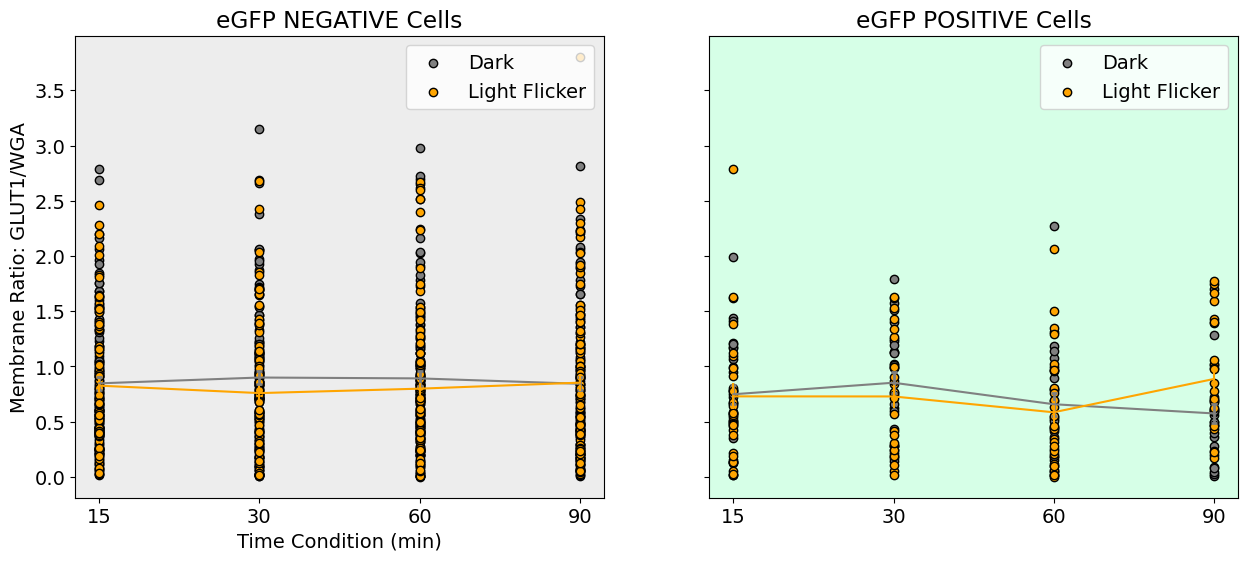

In [158]:
desired_order = ['15', '30', '60', '90']
sim_data['Time_Condition'] = pd.Categorical(sim_data['Time_Condition'], categories=desired_order, ordered=True)
sim_data = sim_data.sort_values('Time_Condition')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey = True)  # 2 rows, 1 column


sim_data_eGFP = sim_data.loc[sim_data['eGFP_Value'] == 1]
sim_data_noneGFP = sim_data.loc[sim_data['eGFP_Value'] == 0]


ax1.scatter(data = sim_data_noneGFP.loc[sim_data_noneGFP['Exp_Condition'] == 'Dark'], x = 'Time_Condition', y = 'Ratios',
            label = 'Dark', c = 'grey', edgecolors = 'black')
ax1.scatter(data = sim_data_noneGFP.loc[sim_data_noneGFP['Exp_Condition'] == 'Light Flicker'], x = 'Time_Condition', y = 'Ratios',
            label = 'Light Flicker', c = 'orange', edgecolors = 'black')

ax1.legend(loc = 'upper right')

ax2.scatter(data = sim_data_eGFP.loc[sim_data_eGFP['Exp_Condition'] == 'Dark'], x = 'Time_Condition', y = 'Ratios',
            label = 'Dark', c = 'grey', edgecolors = 'black')
ax2.scatter(data = sim_data_eGFP.loc[sim_data_eGFP['Exp_Condition'] == 'Light Flicker'], x = 'Time_Condition', y = 'Ratios',
            label = 'Light Flicker', c = 'orange', edgecolors = 'black')

ax2.legend(loc = 'upper right')

### Code for errorbars

grouped_data_noneGFP = sim_data_noneGFP.groupby(['Exp_Condition', 'Time_Condition']).agg(
    Mean_Ratio=('Ratios', 'mean'),
    Std_Error=('Ratios', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

ax1.errorbar(data = grouped_data_noneGFP.loc[grouped_data_noneGFP['Exp_Condition'] == 'Dark'], x = 'Time_Condition', y = 'Mean_Ratio', yerr= 'Std_Error',
             label = None, c = 'Grey', capsize = 2, capthick = 2, elinewidth = 2)
ax1.errorbar(data = grouped_data_noneGFP.loc[grouped_data_noneGFP['Exp_Condition'] == 'Light Flicker'], x = 'Time_Condition', y = 'Mean_Ratio', yerr= 'Std_Error',
             label = None, c = 'orange')

grouped_data_eGFP = sim_data_eGFP.groupby(['Exp_Condition', 'Time_Condition']).agg(
    Mean_Ratio=('Ratios', 'mean'),
    Std_Error=('Ratios', lambda x: np.std(x) / np.sqrt(len(x)))
).reset_index()

ax2.errorbar(data = grouped_data_eGFP.loc[grouped_data_eGFP['Exp_Condition'] == 'Dark'], x = 'Time_Condition', y = 'Mean_Ratio', yerr= 'Std_Error',
             label = None, c = 'Grey', capsize = 2, capthick = 2, elinewidth = 2)
ax2.errorbar(data = grouped_data_eGFP.loc[grouped_data_eGFP['Exp_Condition'] == 'Light Flicker'], x = 'Time_Condition', y = 'Mean_Ratio', yerr= 'Std_Error',
             label = None, c = 'orange')

### Ax title and background
ax1.set_title('eGFP NEGATIVE Cells')
ax1.set_facecolor('#ededed')
ax1.set_ylabel('Membrane Ratio: GLUT1/WGA')
ax1.set_xlabel('Time Condition (min)')

ax2.set_title('eGFP POSITIVE Cells')
ax2.set_facecolor('#d6ffe7')